In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1269.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/623.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/820.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1354.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/45.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/369.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1711.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1173.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1488.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/436.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1409.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/71.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1055.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/215.jpg
/

In [2]:
!pip install imutils
#pip install --upgrade tensorflow keras

In [3]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer  
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf  # tensorflow is an open source library 
from tensorflow.keras.models import Sequential # keras - neural network library
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K       # well optimized tensor manipulation library 
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from random import randint
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#loss='binary_crossentropy'
#metrics = ['accuracy']
#opt = SGD(0.01)

In [5]:
#from keras.optimizers import utils as optimizer_utils
class FedProxOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, server_weights, lr, mu, name='FedProxOptimizer', **kwargs):
        super(FedProxOptimizer, self).__init__(name, **kwargs)
        self._learning_rate = lr
        self._mu = mu
        self.server_weights = server_weights
       # self.client_weights = client_weights    # same as variable
        self.times = 0
        
    
    def update_step(self, gradient, variable):                 # server_controls, client_controls,
        if self.times < len(self.server_weights):
        #    print(f'gradient = {gradient.shape}, variables = {variable.shape}, server = {self.server_weights[self.times].shape}')
        #    print(f'mu = {self._mu}')
        #    print(f'variable = {type(variable)} and vstar = {type(self.server_weights[self.times])}')
            grad = gradient + self._mu * ( variable - self.server_weights[self.times] )  
        #    print(f'grad = {grad}')                                    # gradient calculation, self.get_slot(v, c/ci{i}) 
            variable.assign_sub(self.learning_rate * grad)
        #    print(f'variable = {variable}')
            self.times += 1
        return 

    def get_config(self):
        config = super(FedProxOptimizer, self).get_config()
        config.update({
            'vstar': self.server_weights,
        #    'v': variable,
            'learning_rate': self.learning_rate
        })
        return config

In [6]:
def Xcep():
    img_size = 168
        
    model = Sequential() # Model is created
    model_name = Xception
    base = Xception(include_top=False, weights="imagenet", input_shape=(img_size,img_size,3), pooling='avg')#CNN based binary classification on a pre-trained model 
    for lay in base.layers: lay.trainable = True # false for transfer learning
    model.add(base)
    model.add(Dropout(0.8))                      #Dropout layers to prevent overfitting
    model.add(Flatten())
    model.add(Dense(64,'relu')) 
    model.add(Dropout(0.6))
    model.add(Dense(1,'sigmoid'))                #sigmoid as activation function and adam as optimizer
  
    return model
#print(model.get_weights()[0][0][0][0])

In [7]:
path = '/kaggle/input/skin-cancer-malignant-vs-benign'
# combine test, train
img_size = 168
ben_train_images = [] # os.listdir(path + '/train/benign')
mal_train_images = [] # os.listdir(path + '/train/malignant')
ben_test_images = []  #os.listdir(path + '/test/benign')
mal_test_images = []  # os.listdir(path + '/test/malignant')

ben_train_labels = [] # os.listdir(path + '/train/benign')
mal_train_labels = [] # os.listdir(path + '/train/malignant')
ben_test_labels = []  #os.listdir(path + '/test/benign')
mal_test_labels = []  # os.listdir(path + '/test/malignant')

images_ben = []                # contain flattened images
images_mal = [] 
labels_ben = []              # contain corresponding labels
labels_mal = []

ben = os.listdir(path + '/train/benign')    #ben_train + ben_test
mal = os.listdir(path + '/train/malignant') #mal_train + mal_test
#print(mal)
random.shuffle(ben)
random.shuffle(mal)
   # ben=ben[0:389]
   # mal=mal[0:480]
                   
    # Let benign be 0 and malignant be 1

for i in ben:
    x = path + '/train/benign/' + i
    img = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB) #Convert Image from BGR to RGB 
    img = cv2.resize(img,(img_size,img_size))                      #Resizing the image
    img = img/255                                        #normalising 
    ben_train_images.append(img)                          #Flattens to 1D array
    ben_train_labels.append(0)
    
for i in mal:
    x = path + '/train/malignant/' + i
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(img_size,img_size))
    img = img/255 # normalising 
    mal_train_images.append(img)
    mal_train_labels.append(1)
    
ben = os.listdir(path + '/test/benign')    #ben_train + ben_test
mal = os.listdir(path + '/test/malignant') #mal_train + mal_test
random.shuffle(ben)
random.shuffle(mal)
   # ben=ben[0:389]
   # mal=mal[0:480]
                   
    # Let benign be 0 and malignant be 1

for i in ben:
    x = path + '/test/benign/' + i
    img = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB) #Convert Image from BGR to RGB 
    img = cv2.resize(img,(img_size,img_size))                      #Resizing the image
    img = img/255                                        #normalising 
    ben_test_images.append(img)                          #Flattens to 1D array
    ben_test_labels.append(0)
for i in mal:
    x = path + '/test/malignant/' + i
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(img_size,img_size))
    img = img/255 # normalising 
    mal_test_images.append(img)
    mal_test_labels.append(1)
    
ben_train_images = np.array(ben_train_images)
mal_train_images = np.array(mal_train_images)

ben_train_labels = np.array(ben_train_labels)
mal_train_labels = np.array(mal_train_labels)

ben_test_images = np.array(ben_test_images)
mal_test_images = np.array(mal_test_images)

ben_test_labels = np.array(ben_test_labels)
mal_test_labels = np.array(mal_test_labels)

print(f'train_images_ben, test = {ben_train_images.shape, ben_test_images.shape}, train_images_mal = {mal_train_images.shape, mal_test_images.shape}')
print(f'train_labels_ben = {ben_train_labels.shape, ben_test_labels.shape},labels_mal = {mal_train_labels.shape, mal_test_labels.shape}')

train_images_ben, test = ((1440, 168, 168, 3), (360, 168, 168, 3)), train_images_mal = ((1197, 168, 168, 3), (300, 168, 168, 3))
train_labels_ben = ((1440,), (360,)),labels_mal = ((1197,), (300,))


In [8]:
iid = 0
if iid:
    print('iid')
    client_0_train_images = np.concatenate((ben_train_images[:470], mal_train_images[:389]), axis = 0)
    print(f'client 0, ben = {len(ben_train_images[:470])} and mal = {len(mal_train_images[:389])}')
    client_0_train_labels = np.concatenate((ben_train_labels[:470], mal_train_labels[:389]), axis = 0)

    client_1_train_images = np.concatenate((ben_train_images[470:950], mal_train_images[389:767]), axis = 0)
    print(f'client 1, ben = {len(ben_train_images[470:950])} and mal = {len(mal_train_images[389:767])}')
    client_1_train_labels = np.concatenate((ben_train_labels[470:950], mal_train_labels[389:767]), axis = 0)

    client_2_train_images = np.concatenate((ben_train_images[950:], mal_train_images[767:]), axis = 0)
    print(f'client 2, ben = {len(ben_train_images[950:])} and mal = {len(mal_train_images[767:])}')
    client_2_train_labels = np.concatenate((ben_train_labels[950:], mal_train_labels[767:]), axis = 0)
else:  
    print('non-iid')
    # noniid
    client_0_train_images = np.concatenate((ben_train_images[:1220], mal_train_images[:100]),axis = 0) 
    print(f'client 0, ben = {len(ben_train_images[:1220])} and mal = {len(mal_train_images[:100])}')
    client_0_train_labels = np.concatenate((ben_train_labels[:1220], mal_train_labels[:100]),axis = 0)

    client_1_train_images = np.concatenate((ben_train_images[1220:1345], mal_train_images[100:210]),axis = 0)
    print(f'client 1, ben = {len(ben_train_images[1220:1345])} and mal = {len(mal_train_images[100:210])}')
    client_1_train_labels = np.concatenate((ben_train_labels[1220:1345], mal_train_labels[100:210]),axis = 0)

    client_2_train_images = np.concatenate((ben_train_images[1345:], mal_train_images[210:]),axis = 0)
    print(f'client 2, ben = {len(ben_train_images[1345:])} and mal = {len(mal_train_images[210:])}')
    client_2_train_labels = np.concatenate((ben_train_labels[1345:], mal_train_labels[210:]),axis = 0)

client_0_test_images = np.concatenate((ben_test_images[:120], mal_test_images[:100]),axis = 0)
client_0_test_labels = np.concatenate((ben_test_labels[:120], mal_test_labels[:100]),axis = 0)

client_1_test_images = np.concatenate((ben_test_images[120:240], mal_test_images[100:200]),axis = 0)
client_1_test_labels = np.concatenate((ben_test_labels[120:240], mal_test_labels[100:200]),axis = 0)

client_2_test_images = np.concatenate((ben_test_images[240:], mal_test_images[200:]),axis = 0)
client_2_test_labels = np.concatenate((ben_test_labels[240:], mal_test_labels[200:]),axis = 0)

client_data_train_images = {}
client_data_train_images['client0'] = client_0_train_images
client_data_train_images['client1'] = client_1_train_images
client_data_train_images['client2'] = client_2_train_images

client_data_test_images = {}
client_data_test_images['client0'] = client_0_test_images
client_data_test_images['client1'] = client_1_test_images
client_data_test_images['client2'] = client_2_test_images

client_data_train_labels = {}
client_data_train_labels['client0'] = client_0_train_labels
client_data_train_labels['client1'] = client_1_train_labels
client_data_train_labels['client2'] = client_2_train_labels

client_data_test_labels = {}
client_data_test_labels['client0'] = client_0_test_labels
client_data_test_labels['client1'] = client_1_test_labels
client_data_test_labels['client2'] = client_2_test_labels

#print(f' client0 = images = {client_0_images.shape} and labels = {client_0_labels.shape}')
#print(f' client1 = images = {client_1_images.shape} and labels = {client_1_labels.shape}')
#print(f' client2 = images = {client_2_images.shape} and labels = {client_2_labels.shape}')

#client_0_train_images, client_0_test_images, client_0_train_labels, client_0_test_labels = train_test_split(client_0_images,client_0_labels, test_size = 0.2)
#client_1_train_images, client_1_test_images, client_1_train_labels, client_1_test_labels = train_test_split(client_1_images,client_1_labels, test_size = 0.2)
#client_2_train_images, client_2_test_images, client_2_train_labels, client_2_test_labels = train_test_split(client_2_images,client_2_labels, test_size = 0.2)

print(f' client0 = images = {client_0_train_images.shape, client_0_test_images.shape} and labels = {client_0_train_labels.shape, client_0_test_labels.shape}')
print(f' client1 = images = {client_1_train_images.shape, client_1_test_images.shape} and labels = {client_1_train_labels.shape, client_1_test_labels.shape}')
print(f' client2 = images = {client_2_train_images.shape, client_2_test_images.shape} and labels = {client_2_train_labels.shape, client_2_test_labels.shape}')

initial='client'
N = 3
client_names = ['{}{}'.format(initial, i) for i in range(N)]

non-iid
client 0, ben = 1220 and mal = 100
client 1, ben = 125 and mal = 110
client 2, ben = 95 and mal = 987
 client0 = images = ((1320, 168, 168, 3), (220, 168, 168, 3)) and labels = ((1320,), (220,))
 client1 = images = ((235, 168, 168, 3), (220, 168, 168, 3)) and labels = ((235,), (220,))
 client2 = images = ((1082, 168, 168, 3), (220, 168, 168, 3)) and labels = ((1082,), (220,))


In [9]:
#for i in range(3): shutil.rmtree(f'round{i}')
#for i in range(3): os.mkdir(f'round{i}')

path = '/kaggle/input/skin-cancer-malignant-vs-benign'
path_model = '/kaggle/working/'

In [10]:
round0 = {}

tr_acc_0 = {}
tr_loss_0 = {}

test_acc_0 = {}
test_loss_0 = {}

tr_loss_all = {}
test_acc_all = {}

In [11]:
def process_train_test(weights, server_weights, client, epochs):
    
    loss='binary_crossentropy'
    metrics = ['accuracy']
    opt = FedProxOptimizer(server_weights, 0.01, 0.01)
    
    model = Xcep()
    model.compile(loss = loss, optimizer = opt, metrics = metrics)
    
    model.set_weights(weights)
    
  #  global path                        
  
    train_images, train_labels = client_data_train_images[client], client_data_train_labels[client] 
    
    test_images, test_labels = client_data_test_images[client], client_data_test_labels[client] 
    h = model.fit(train_images,train_labels, validation_data = (test_images, test_labels), verbose = 0, epochs=epochs,batch_size=10)

  #  path_save = '/content/round1/'
  #  model.save(path_save + "client2_round1.h5")
  #  print("Model of client 3 saved")
    return model, h.history['accuracy'], h.history['loss'], h.history['val_accuracy'], h.history['val_loss']

In [12]:
# round 0
N = 3 # number of clients
epochs = 1
print('round 0')

for n in range(N):
    model = Xcep()
    print(f'client {n}')
    model, tr_a, tr_l, test_a, test_l = process_train_test(model.get_weights(), model.trainable_variables, f'client{n}', epochs)
   # tr_acc_0[f'client{n}'] = tr_a
    tr_loss_all[f'client{n}'] = [tr_l[epochs-1]]
    test_acc_all[f'client{n}'] = [test_a[epochs-1]]
   # test_loss_0[f'client{n}'] = test_l
    round0[f'client{n}'] = model

round 0
client 0
client 1
client 2


In [13]:
def evaluate(weights, server_weights, client):
    
    loss='binary_crossentropy'
    metrics = ['accuracy']
    opt = FedProxOptimizer(server_weights, 0.01, 0.01)
    
    model = Xcep()
    model.compile(loss = loss, optimizer = opt, metrics = metrics)
    
    model.set_weights(weights)

    test_images, test_labels = client_data_test_images[client], client_data_test_labels[client] 
  
    l,a = model.evaluate(test_images,test_labels,verbose=2)
    print('curr_acc: {:.4%} | curr_loss: {:.4} '.format(a, l))
    return a,l

In [14]:
def scale_model_weights(weight, scalar):
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final # list of scaled weights of the local model

# list containing scaled weights of all local models / clients
def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad

def aggregate(files):
    scaled_local_weight_list = list()
    c = 0
    model = Xcep()
    average_weights = None
    for m in files.values(): 
        sca_factor = [0.3257, 0.3254, 0.3489]       #[0.5006,0.0891,0.4103]    # [0.3257, 0.3254, 0.3489]    # [0.4316,0.1964,0.372]
        #path=directory+'/'+i
        #print(path)
       # model = load_model(directory + p)
        scaled_weights = scale_model_weights(m.get_weights(), sca_factor[c])
        c += 1
        scaled_local_weight_list.append(scaled_weights)
        average_weights = sum_scaled_weights(scaled_local_weight_list)
    model.set_weights(average_weights)
    return model.get_weights(), model.trainable_variables

#def avg_loss_acc()

In [15]:
#initialize global model
global_model = Xcep()  # class object
comm_rounds = 10
round_curr = dict(round0)

#commence global training loop 
for comm_round in range(comm_rounds):
            
    print(f'comm round = {comm_round}')
    round_prev = round_curr.copy()
    global_weights, global_trainable_weights = aggregate(round_prev)
    round_curr = {}
    
    avg_train_loss = 0
    avg_test_acc = 0

    #loop through each client and create new local model
    for c, client in enumerate(client_names):

        print(f'client name = {client}')
        test_a, test_l = evaluate(global_weights, global_trainable_weights, client)
        # add to graph (client, round number)
        loss='binary_crossentropy'
        metrics = ['accuracy']
        opt = FedProxOptimizer(global_trainable_weights, 0.01, 0.01)
    
        local_model = Xcep()
        local_model.compile(loss = loss, optimizer = opt, metrics = metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        train_images, train_labels = client_data_train_images[client], client_data_train_labels[client] 
       
        test_images, test_labels = client_data_test_images[client], client_data_test_labels[client] 
       
        h = model.fit(train_images,train_labels, validation_data = (test_images, test_labels),epochs=epochs,batch_size=10, verbose = 0)

        tr_loss = h.history['loss'][epochs-1]
        print('aggregated_test_acc: {:.4%} | local_train_loss: {:.4} '.format(test_a, tr_loss))
        
        round_curr[client] = model
        #scale the model weights and add to list
       
        tr_loss_all[client].append(tr_loss)
        test_acc_all[client].append(test_a)

        #clear session to free memory after each communication round
        
        K.clear_session()


comm round = 0
client name = client0
7/7 - 4s - loss: 0.6890 - accuracy: 0.5318 - 4s/epoch - 610ms/step
curr_acc: 53.1818% | curr_loss: 0.689 
aggregated_test_acc: 53.1818% | local_train_loss: 0.5347 
client name = client1
7/7 - 2s - loss: 0.6910 - accuracy: 0.5045 - 2s/epoch - 288ms/step
curr_acc: 50.4545% | curr_loss: 0.691 
aggregated_test_acc: 50.4545% | local_train_loss: 0.8333 
client name = client2
7/7 - 2s - loss: 0.6915 - accuracy: 0.4727 - 2s/epoch - 284ms/step
curr_acc: 47.2727% | curr_loss: 0.6915 
aggregated_test_acc: 47.2727% | local_train_loss: 0.4405 
comm round = 1
client name = client0
7/7 - 2s - loss: 0.8930 - accuracy: 0.4545 - 2s/epoch - 286ms/step
curr_acc: 45.4545% | curr_loss: 0.893 
aggregated_test_acc: 45.4545% | local_train_loss: 0.546 
client name = client1
7/7 - 3s - loss: 0.8883 - accuracy: 0.4545 - 3s/epoch - 462ms/step
curr_acc: 45.4545% | curr_loss: 0.8883 
aggregated_test_acc: 45.4545% | local_train_loss: 0.7882 
client name = client2
7/7 - 2s - loss: 

# Evaluate

In [16]:
for client in client_names:
   # tr_loss_all[client][0] = tr_loss_all[client][0][epochs-1]
   # test_acc_all[client][0] = test_acc_all[client][0][epochs-1]
    
    print(f'client {client} train loss  = {tr_loss_all[client]}')
    print(f'client {client} test acc = {test_acc_all[client]}')

client client0 train loss  = [0.3431919515132904, 0.5347034335136414, 0.545979380607605, 0.5137916207313538, 0.5339362621307373, 0.5072100758552551, 0.4888690710067749, 0.5228872299194336, 0.5001221895217896, 0.5015825629234314, 0.4912516176700592]
client client0 test acc = [0.5454545617103577, 0.5318182110786438, 0.4545454680919647, 0.4545454680919647, 0.4636363685131073, 0.5545454621315002, 0.6409090757369995, 0.699999988079071, 0.7590909004211426, 0.7636363506317139, 0.7772727012634277]
client client1 train loss  = [0.7895394563674927, 0.8332856297492981, 0.7881819605827332, 0.7301473617553711, 0.7110096216201782, 0.6545866131782532, 0.6132528185844421, 0.5792105793952942, 0.5360656976699829, 0.4779118001461029, 0.4468002915382385]
client client1 test acc = [0.48636364936828613, 0.5045454502105713, 0.4545454680919647, 0.4545454680919647, 0.4681818187236786, 0.6136363744735718, 0.6590909361839294, 0.7136363387107849, 0.7636363506317139, 0.7681818008422852, 0.7863636612892151]
client 

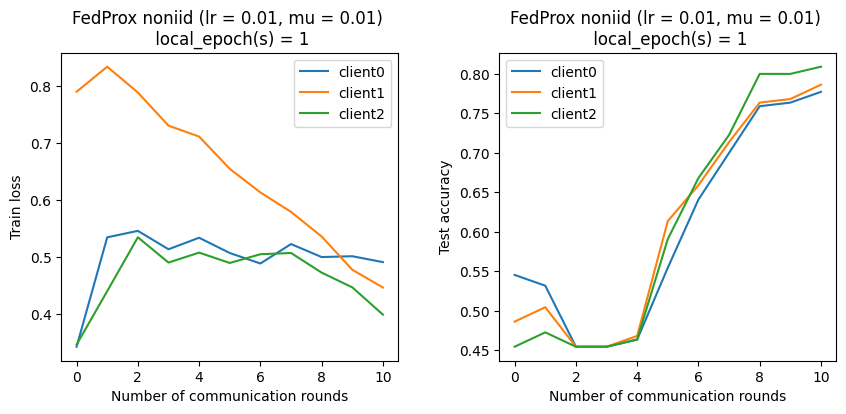

In [18]:
# graph

x = np.arange(comm_rounds + 1)
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)

for client in client_names:
    ax1.plot(x, tr_loss_all[client], label=client)

ax1.legend()
ax1.set_title('FedProx noniid (lr = 0.01, mu = 0.01) \n local_epoch(s) = 1')
ax1.set_xlabel('Number of communication rounds')
ax1.set_ylabel('Train loss')

    
for client in client_names:
    ax2.plot(x, test_acc_all[client], label=client)

ax2.legend()
ax2.set_title('FedProx noniid (lr = 0.01, mu = 0.01) \n local_epoch(s) = 1')
ax2.set_xlabel('Number of communication rounds')
ax2.set_ylabel('Test accuracy')

plt.show()